# load data

In [1]:
import pandas as pd

df = pd.read_parquet('../results/kis_n2v_viability.parquet')

# add drug-cell line combo
df['drug_cell_group'] = df['drug'] + "_" + df['depmap_id']

# drop columns that start with inh_
df = df.loc[:, ~df.columns.str.startswith('inh_')]

print('unique drugs:', df['drug'].nunique())
print('unique concs:', df['concentration_M'].nunique())
print('unique cell lines:', df['depmap_id'].nunique())
print('unique drug-cell line combos:', df['drug_cell_group'].nunique())

df

unique drugs: 168
unique concs: 8
unique cell lines: 480
unique drug-cell line combos: 62472


,drug,concentration_M,depmap_id,viability,drug_cell_group,n2v_0,n2v_1,n2v_2,n2v_3,n2v_4,...,n2v_118,n2v_119,n2v_120,n2v_121,n2v_122,n2v_123,n2v_124,n2v_125,n2v_126,n2v_127
0,AC-480,3.000000e-09,ACH-000007,1.000000,AC-480_ACH-000007,-2.064513,-15.151094,13.043871,9.861311,18.769324,...,-0.575704,3.863768,-36.401104,-41.663105,-29.754678,1.892119,-44.746850,-20.327970,-6.863983,3.753073
1,AC-480,3.000000e-09,ACH-000011,1.000000,AC-480_ACH-000011,-2.064513,-15.151094,13.043871,9.861311,18.769324,...,-0.575704,3.863768,-36.401104,-41.663105,-29.754678,1.892119,-44.746850,-20.327970,-6.863983,3.753073
2,AC-480,3.000000e-09,ACH-000019,1.000000,AC-480_ACH-000019,-2.064513,-15.151094,13.043871,9.861311,18.769324,...,-0.575704,3.863768,-36.401104,-41.663105,-29.754678,1.892119,-44.746850,-20.327970,-6.863983,3.753073
3,AC-480,3.000000e-09,ACH-000021,0.999895,AC-480_ACH-000021,-2.064513,-15.151094,13.043871,9.861311,18.769324,...,-0.575704,3.863768,-36.401104,-41.663105,-29.754678,1.892119,-44.746850,-20.327970,-6.863983,3.753073
4,AC-480,3.000000e-09,ACH-000026,1.000000,AC-480_ACH-000026,-2.064513,-15.151094,13.043871,9.861311,18.769324,...,-0.575704,3.863768,-36.401104,-41.663105,-29.754678,1.892119,-44.746850,-20.327970,-6.863983,3.753073
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
449306,Y-39983,3.000000e-05,ACH-000972,0.977581,Y-39983_ACH-000972,-1.535494,-13.841755,14.177363,8.501278,17.853024,...,-0.213327,2.425333,-33.243426,-37.334694,-28.285682,2.482509,-39.911773,-17.410111,-6.027881,3.403830
449307,Y-39983,3.000000e-05,ACH-000973,0.017294,Y-39983_ACH-000973,-1.535494,-13.841755,14.177363,8.501278,17.853024,...,-0.213327,2.425333,-33.243426,-37.334694,-28.285682,2.482509,-39.911773,-17.410111,-6.027881,3.403830
449308,Y-39983,3.000000e-05,ACH-000990,0.011341,Y-39983_ACH-000990,-1.535494,-13.841755,14.177363,8.501278,17.853024,...,-0.213327,2.425333,-33.243426,-37.334694,-28.285682,2.482509,-39.911773,-17.410111,-6.027881,3.403830
449309,Y-39983,3.000000e-05,ACH-001024,0.110570,Y-39983_ACH-001024,-1.535494,-13.841755,14.177363,8.501278,17.853024,...,-0.213327,2.425333,-33.243426,-37.334694,-28.285682,2.482509,-39.911773,-17.410111,-6.027881,3.403830


# 10 fold cv grouped by drug-cell line combo

100%|██████████| 10/10 [06:20<00:00, 38.06s/it]

Random Forest
	R^2 mean: 0.7293163002391194
	R^2 std: 0.002099506115675488
	RMSE mean: 0.17379003563234646
	RMSE std: 0.0007901704359389733
XGBoost
	R^2 mean: 0.7293170904070522
	R^2 std: 0.0021073633841615044
	RMSE mean: 0.17378976827486545
	RMSE std: 0.0007914607592281791


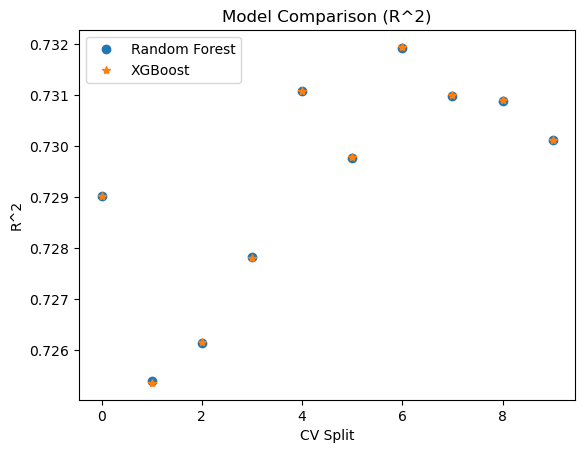

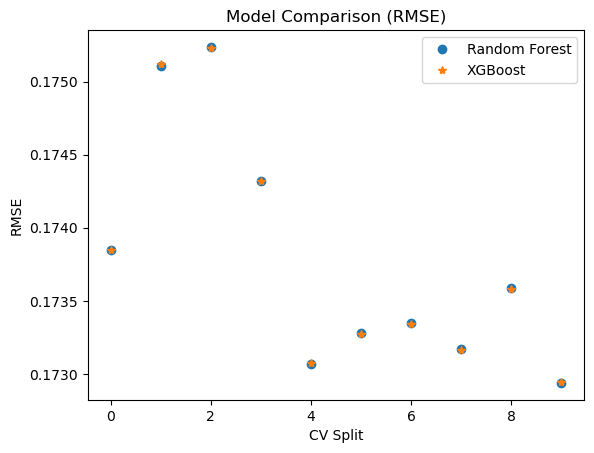

In [2]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GroupKFold
from sklearn.metrics import r2_score, root_mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
import tqdm

# X, y, and grouping
X = df.drop(columns=['drug', 'concentration_M', 'depmap_id', 'viability', 'drug_cell_group'])
y = df['viability']
groups = df['drug_cell_group']
gkf = GroupKFold(n_splits=10)

# cv loop
rf_r2 = []
rf_rmse = []
xgb_r2 = []
xgb_rmse = []

for train_index, test_index in tqdm.tqdm(gkf.split(X, y, groups=groups), total=gkf.get_n_splits(X, y, groups=groups)):
    # X, y
    X_train = X.iloc[train_index]
    X_test = X.iloc[test_index]
    y_train = y.iloc[train_index]
    y_test = y.iloc[test_index]

    # model RF
    model_rf = RandomForestRegressor(n_jobs=-1)
    model_rf.fit(X_train, y_train)
    y_pred_rf = model_rf.predict(X_test)
    rf_r2.append(r2_score(y_test, y_pred_rf))
    rf_rmse.append(root_mean_squared_error(y_test, y_pred_rf))

    # model XGB
    model_xgb = XGBRegressor(n_jobs=-1)
    model_xgb.fit(X_train, y_train)
    y_pred_xgb = model_xgb.predict(X_test)
    xgb_r2.append(r2_score(y_test, y_pred_xgb))
    xgb_rmse.append(root_mean_squared_error(y_test, y_pred_xgb))

rf_r2 = np.array(rf_r2)
rf_rmse = np.array(rf_rmse)
xgb_r2 = np.array(xgb_r2)
xgb_rmse = np.array(xgb_rmse)

print('Random Forest')
print('\tR^2 mean:', rf_r2.mean())
print('\tR^2 std:', rf_r2.std())
print('\tRMSE mean:', rf_rmse.mean())
print('\tRMSE std:', rf_rmse.std())

print('XGBoost')
print('\tR^2 mean:', xgb_r2.mean())
print('\tR^2 std:', xgb_r2.std())
print('\tRMSE mean:', xgb_rmse.mean())
print('\tRMSE std:', xgb_rmse.std())

# plot r2
plt.plot(rf_r2, 'o', label='Random Forest')
plt.plot(xgb_r2, '*', label='XGBoost')
plt.xlabel('CV Split')
plt.ylabel('R^2')
plt.title('Model Comparison (R^2)')
plt.legend()
plt.show()

# plot rmse
plt.plot(rf_rmse, 'o', label='Random Forest')
plt.plot(xgb_rmse, '*', label='XGBoost')
plt.xlabel('CV Split')
plt.ylabel('RMSE')
plt.title('Model Comparison (RMSE)')
plt.legend()
plt.show()

# save results to npz
np.savez('../results/n2v_results.npz',
         rf_r2=rf_r2,
         rf_rmse=rf_rmse,
         xgb_r2=xgb_r2,
         xgb_rmse=xgb_rmse)

# RF model from paper
# model = RandomForestRegressor(n_estimators=500, max_features=22, min_samples_leaf=5, n_jobs=-1)

# equivalent, but slower
# from sklearn.model_selection import cross_val_score
# scores_rf = cross_val_score(RandomForestRegressor(n_jobs=-1), X, y, groups=groups, cv=gkf)
# scores_xgb = cross_val_score(XGBRegressor(n_jobs=-1), X, y, groups=groups, cv=gkf)